### Generic function to define a chirp pulse

In [ ]:
def load_chirp(channels = [{'name': 'a_ch0', 'amp': 1.00, 'phase':0, 'start_freq':2.8e9, ,'stop_freq':3e9}], 
             dur=1e-6, identifier=''):
    """
    Load a chirp waveform to be played simultaneously on the specified channels.
    """
    ele = []
    a_ch = {'a_ch0': SF.DC(0), 'a_ch1': SF.DC(0), 'a_ch2': SF.DC(0), 'a_ch3': SF.DC(0)}
    d_ch = {'d_ch0': False, 'd_ch1': False, 'd_ch2': False, 'd_ch4': False, 'd_ch3': False, 'd_ch5': False}
    for ch in channels:
        a_ch[ch['name']] = SF.Chirp(amplitude=ch['amp'], start_freq=ch['start_freq'], stop_freq=ch['stop_freq'], 
                                    phase=ch['phase'])

    ele.append(po.PulseBlockElement(init_length_s=dur,  pulse_function=a_ch, digital_high=d_ch))
    pulse_block = po.PulseBlock(name=f'ChirpAutoAFMCon', element_list=ele)
    self._pulsed_master_AWG.sequencegeneratorlogic().save_block(pulse_block)

    block_list = []
    block_list.append((pulse_block.name, 0))
    auto_pulse_CW = po.PulseBlockEnsemble(f'ChirpAutoAFMCon{identifier}', block_list)

    ensemble = auto_pulse_CW
    ensemblename = auto_pulse_CW.name
    afm_confocal_logic._pulsed_master_AWG.sequencegeneratorlogic().save_ensemble(ensemble)
    afm_confocal_logic._pulsed_master_AWG.sequencegeneratorlogic().sample_pulse_block_ensemble(ensemblename)
    afm_confocal_logic._pulsed_master_AWG.sequencegeneratorlogic().load_ensemble(ensemblename)

### Function to define chirp pulse with IQ mixer and LO for given duration (time, freq) and power

In [ ]:
def load_IQ_chirp(LO_freq, start_freq, stop_freq, duration, power):
        """
        Runs a simple sin voltage sequence in regular stream mode on the AWG.
        """
        afm_confocal_logic._AWG.pulser_off()
        afm_confocal_logic._AWG.instance.init_all_channels()
        afm_confocal_logic._mw.off()

        start = abs(LO_freq - start_freq) # we always use a higher LO and a low shifiting AWG phase for I and Q. Hardcoded below
        stop = abs(LO_freq - stop_freq) # we always use a higher LO and a low shifiting AWG phase for I and Q. Hardcoded below

        ch = [   {'name': 'a_ch0', 'amp': 1.00, 'start_freq': start, 'stop_freq':stop, 'phase': 0.00},
                 {'name': 'a_ch1', 'amp': 1.20, 'start_freq': start, 'stop_freq':stop, 'phase': 100.00}
             ]
        
        load_chirp(channels = ch, dur = duration, identifier = 'A')
        afm_confocal_logic._mw.set_cw_3(LO_freq, power) # minimal cw set function _3 is used which does not repeat setting of power
        afm_confocal_logic._mw.cw_on_3()

### Upload chirp pulse and ready AWG for trigger - define all sampling and mod. frequencies

In [1]:
# upload the IQ signal for + and - delta frequencies. Should be triggerable. Only the CW MW will change during scan
afm_confocal_logic._pulsed_master_AWG.toggle_pulse_generator(False)
afm_confocal_logic._AWG.instance.init_all_channels()

F_MOD = 1e3 #Hz
F_COUNTER = 50e3 #Hz
SAMP_FREQ = 1 #Hz

############################################
start, stop, duration = (2.82e9, 2.9e9, 1/F_MOD) # start freq, stop freq, duration of a single chirp pulse
############################################
LO_freq = 3e9 # MW frequence for doing IQ sweep
afm_confocal_logic.load_IQ_chirp(LO_freq, start, stop, duration, power)            
afm_confocal_logic._AWG.load_triggered_multi_replay(['ChirpAutoAFMConA']) # refer to load_AWG_sine_for_IQ for names

afm_confocal_logic._pulsed_master_AWG.pulsedmeasurementlogic().pulsegenerator().pulser_on(trigger=True)

NameError: name 'self' is not defined

### Ready timetagger and upload trigger sequence to pulsetreamer

In [ ]:
from hardware.timetagger_counter import HWRecorderMode

# DURATION variable determines f_mod, num of pulsestreamer repetitions determine sampling time at each point

num_runs = int(F_COUNTER/F_MOD)
afm_confocal_logic._pulser.load_swabian_sequence(afm_confocal_logic._make_pulse_sequence('LOCK-IN', int_time=1/F_COUNTER, 
                                                             num_esr_runs=num_runs))
TOTAl_REP = int((1/SAMP_FREQ)/(1/F_MOD))

ret_val = afm_confocal_logic._counter.configure_recorder(mode=HWRecorderMode.LOCKIN,
                                        params={'num_meas': num_runs*TOTAL_REP})

In [ ]:
afm_confocal_logic._counter.start_recorder(arm=True)
afm_confocal_logic._pulser.pulser_on(n=TOTAl_REP)
meas = afm_confocal_logic._counter.get_measurements()[0]

### Determining ODMR shift - test data used here

In [982]:
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('seaborn-v0_8-muted')
data_set1 = np.loadtxt("Data/20230921-1039-48_Set_A_3.5K_8mT_OOP_FC_OOC_ODMR_data_ch0_range0.dat").T
data_set2 = np.loadtxt("Data/20230921-1042-14_Set_A_3.5K_8mT_OOP_FC_5nm_LO_ODMR_data_ch0_range0.dat").T

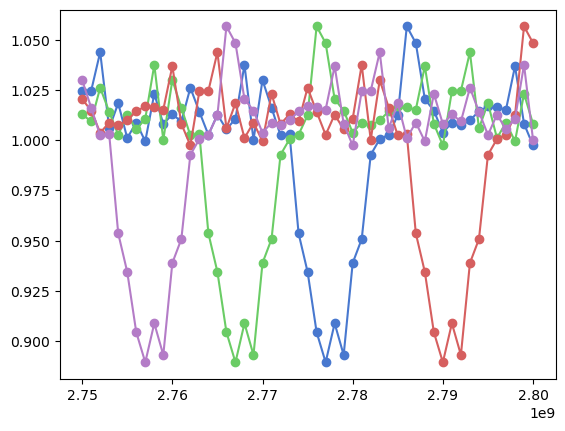

In [983]:
x1,y1 = (data_set1[0], data_set1[1])
plt.plot(x1, y1/y1.mean(), 'o-')
x2,y2 = (data_set2[0], data_set2[1])
# plt.plot(x2, y2/y2.mean(), 'o-')
# plt.show()

y3 = np.roll(y1, -10, axis=0)
plt.plot(x2, y3/y3.mean(), 'o-')

y4 = np.roll(y1, 13, axis=0)
plt.plot(x2, y4/y4.mean(), 'o-')


y5 = np.roll(y1, -20, axis=0)
plt.plot(x2, y5/y5.mean(), 'o-')
plt.show()

### Concatenating and adding noise to make test data

In [984]:
from scipy.fft import fft, ifft, fftfreq

Seed was: 74


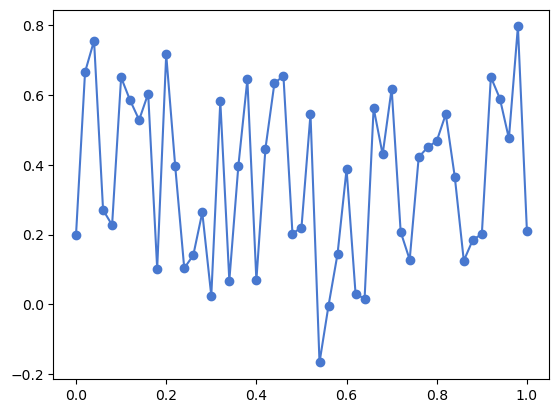

Periodicity: 51


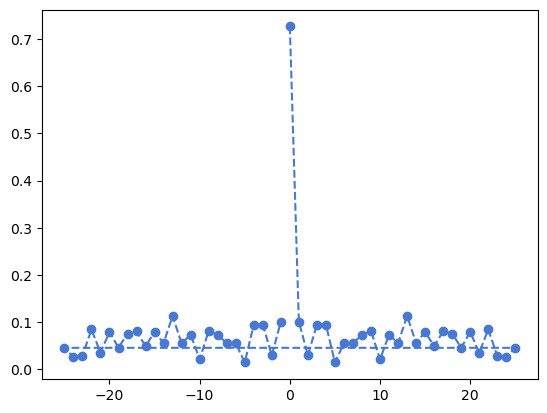

Seed was: 74


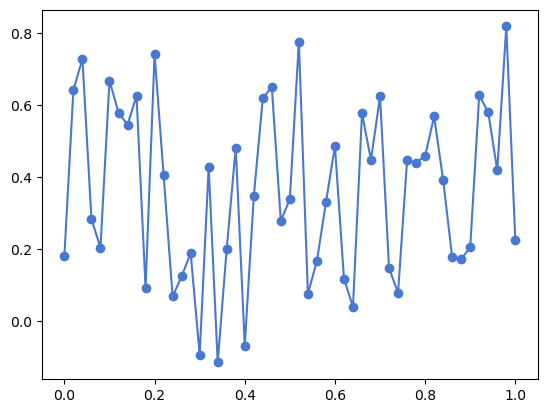

Periodicity: 51


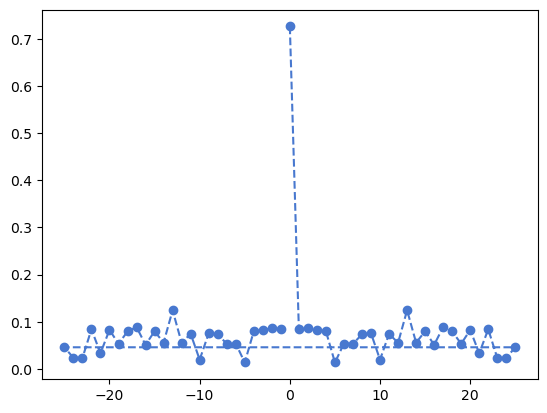

Seed was: 74


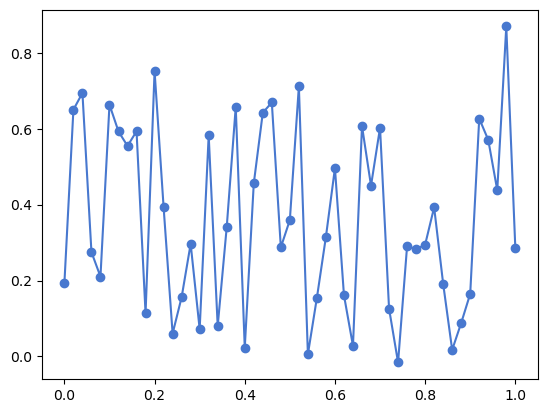

Periodicity: 51


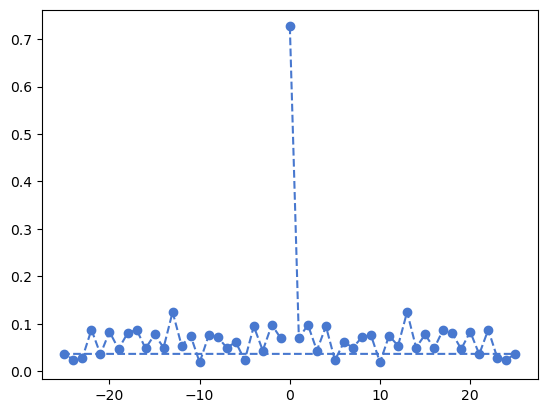

Seed was: 74


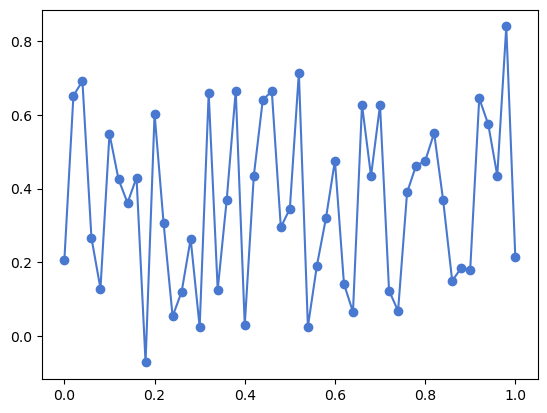

Periodicity: 51


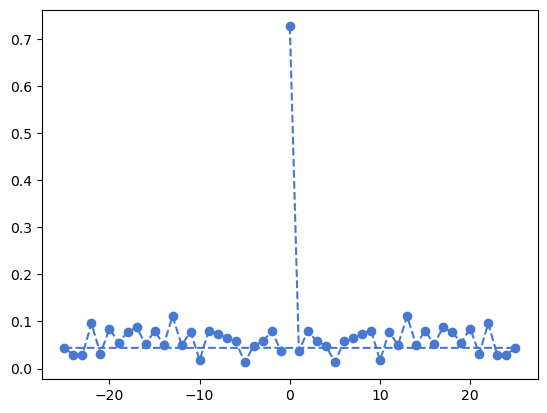

In [999]:
x_axis = x1
to_plot = []
for y_choice in [y1,y3,y4,y5]:

    ### CHOOSE DATASET
    y_raw = y_choice

    y_concatenated = np.tile(y_raw, 1)
#     seed = int(np.random.random()*100)
    np.random.seed(seed)
    print("Seed was:", seed)
    y_concatenated -= y_concatenated.mean()
    y_concatenated += np.random.random((len(y_concatenated)))*0.8
#     y_concatenated += np.random.poisson(lam=0.1, size=len(y_concatenated))
    

    f_center = x_axis[int(len(x_axis)/2)]
    delta_f_win = np.abs(x_axis[-1]-x_axis[0])

    mod_freq = 1 # the modulation frequency of the lockin signal
    T = 1/len(x_axis) / mod_freq #time array is defined to achieve said mod freq. For real, T would be the integration time or bin width
    N = len(y_concatenated)

    x_time = np.linspace(0,T*N,N)

    plt.plot(x_time, y_concatenated,'o-')
    plt.show()
    print('Periodicity:',len(y_raw))


    yf = fft(y_concatenated)
    xf = fftfreq(N, T)
    yplot = 2.0/N* (yf)

    plt.plot(xf, np.abs(yplot),'o--')
#     plt.xlim(0,10)
    plt.show()
    modarg0 = np.abs(xf - mod_freq).argmin()
    

    # Get magnitude and phase
    modarg0 = np.abs(xf - mod_freq).argmin()
    phase0 = np.angle(yplot[modarg0])
    f0 = f_center - (phase0 * delta_f_win /2/ np.pi)

    modarg0 = np.abs(xf - 2*mod_freq).argmin()
    phase0 = np.angle(yplot[modarg0])
    f1 = f_center + (phase0/2 * delta_f_win / 2 / np.pi)/2

    modarg0 = np.abs(xf - 3*mod_freq).argmin()
    phase0 = np.angle(yplot[modarg0])
    f2 = f_center + (phase0/3 * delta_f_win / 2 / np.pi)/3

    result = np.average((f0, f1, f2), weights = (0.5,0.3,0.2))
    
    to_plot.append([x_axis, y_choice, f0])

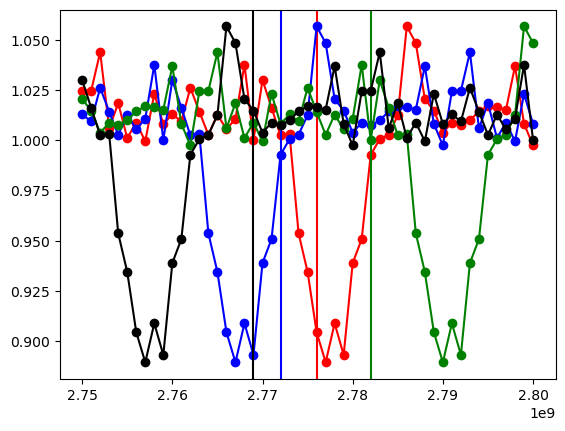

In [1001]:
colors = ['r','b','g','k']
for c,item in enumerate(to_plot):
    x,y,res = item
    plt.plot(x, y/y.mean(), f'{colors[c]}o-')

    v = x_axis[np.abs(x_axis - res).argmin()]
    plt.axvline(x=v, color=f'{colors[c]}')

plt.show()
y_fit0 = y-y.mean()
x_fit = x

### By lmfit

Seed was: 13


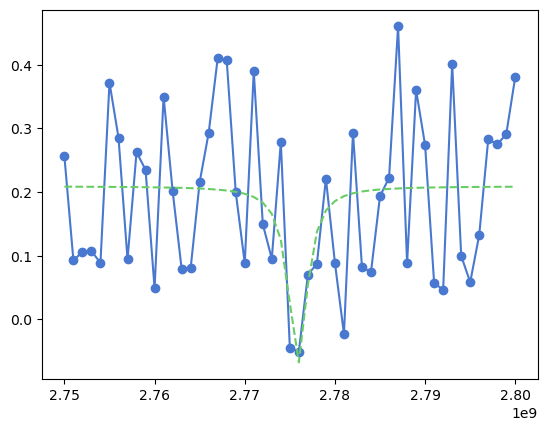

In [750]:
import matplotlib.pyplot as plt
from numpy import exp, loadtxt, pi, sqrt

from lmfit import Model

def lorentzian(x, center, sigma, amp, offset):
        """ Function of a Lorentzian with unit height at center.

        @param numpy.array x: independent variable - e.g. frequency
        @param float center: center around which the distributions will be
        @param float sigma: half length at half maximum

        @return: numpy.array with length equals to input x and with the values
                of a lorentzian.
        """
        return (np.power(sigma, 2) / (np.power((center - x), 2) + np.power(sigma, 2))) * amp + offset
    

# np.random.seed(seed)
print("Seed was:", seed)
y_fit = y_fit0.copy()
y_fit += np.random.random((len(y_fit)))*0.4
lmodel = Model(lorentzian)

result = lmodel.fit(y_fit, x=x_fit, center=2.78e9, sigma=3e6, amp=-0.15, offset=0.2)


plt.plot(x_fit, y_fit, 'o-')
plt.plot(x_fit, result.best_fit, '--')
plt.show()

#### Timing check

48
Res: (MHz) 2777.3394500451695
Diff; (MHz) 0.17256929846954347


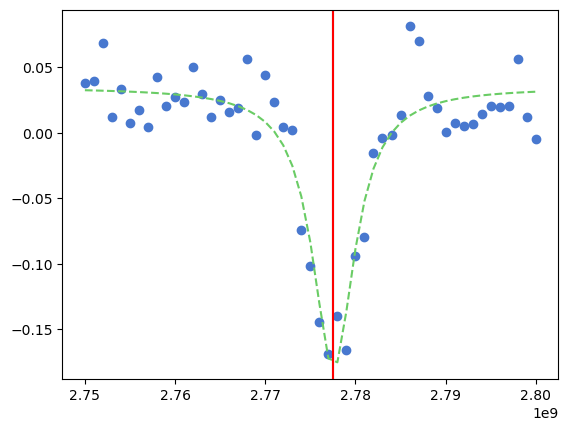

In [1319]:
import timeit

def lorentzian(x, center, sigma, amp, offset):
        """ Function of a Lorentzian with unit height at center.

        @param numpy.array x: independent variable - e.g. frequency
        @param float center: center around which the distributions will be
        @param float sigma: half length at half maximum

        @return: numpy.array with length equals to input x and with the values
                of a lorentzian.
        """
        return (np.power(sigma, 2) / (np.power((center - x), 2) + np.power(sigma, 2))) * amp + offset

def do_fft(seed=None, noise_factor=1e-1):
    x1,y1 = (data_set1[0].copy(), data_set1[1].copy())
    tiling = 20
    y1 = np.tile(y1, tiling)

    if seed:
        np.random.seed(seed)
#     y1 += np.random.random((len(y1)))*0.4
    aft = 0 if len(y1)%2==0 else 1
    y1 = np.pad(y1, (0,aft), 'edge')
    x1 = np.pad(x1, (0,aft), 'edge')
    y_noise = brownian_noise(len(y1))
    y1 += y_noise/y_noise.max()*noise_factor
    y1 -= y1.mean()
    f_center = x_axis[int(len(x1)/2)]
    delta_f_win = np.abs(x1[-1]-x1[0])

    mod_freq = 1 # the modulation frequency of the lockin signal
    T = 1/len(x1) / mod_freq #time array is defined to achieve said mod freq. For real, T would be the integration time or bin width
    N = len(y1)

    x_time = np.linspace(0,T*N,N)

    yf = fft(y1)
    xf = fftfreq(N, T)
    yplot = 2.0/N* (yf)
    
    modarg0 = np.abs(xf - mod_freq).argmin()
    phase0 = np.angle(yplot[modarg0])
    f0 = f_center - (phase0 * delta_f_win /2/ np.pi)
    
    modarg0 = np.abs(xf - 2*mod_freq).argmin()
    phase0 = np.angle(yplot[modarg0])
    f1 = f_center + (phase0/2 * delta_f_win / 2 / np.pi)/2
    
    modarg0 = np.abs(xf - 3*mod_freq).argmin()
    phase0 = np.angle(yplot[modarg0])
    f2 = f_center + (phase0/3 * delta_f_win / 2 / np.pi)/3

    result = np.mean((f0))
    print('Res: (MHz)',result/1e6)
    
    print('Diff; (MHz)', (2777512019.343639-result)/1e6)
#     plt.plot(y1)
# #     plt.axvline(x=result)
# #     plt.axvline(2777512019.343639, color = 'r')
#     plt.show()
    return result


def do_lmfit(seed=None, noise_factor=1e-1):
    x1,y1 = (data_set1[0].copy(), data_set1[1].copy())
    tiling = 20
    y1 = np.tile(y1, tiling)

    if seed:
        np.random.seed(seed)
#     y1 += np.random.random((len(y1)))*0.4
    y_noise = brownian_noise(len(y1))
    y_noise = y_noise[:len(y1)]
    y1 += y_noise/y_noise.max()*noise_factor
    y1 -= y1.mean()
    
#     plt.plot(y1)
#     plt.show()
    
    y1 = y1.reshape((tiling,int(len(y1)/tiling)))
    y1 = np.mean(y1, axis=0)
    
    f_center = x_axis[int(len(x1)/2)]
    delta_f_win = np.abs(x1[-1]-x1[0])

    mod_freq = 1 # the modulation frequency of the lockin signal
    T = 1/len(x1) / mod_freq #time array is defined to achieve said mod freq. For real, T would be the integration time or bin width
    N = len(y1)

    x_time = np.linspace(0,T*N,N)
    
    lmodel = Model(lorentzian)
    result = lmodel.fit(y1, x=x1, center=2.775e9, sigma=8e6, amp=-0.15, offset=0)
    plt.plot(x1, y1, 'o')
    plt.plot(x1, result.best_fit, '--')
    plt.axvline(x=result.params['center'].value)
    plt.axvline(2777512019.343639, color = 'r')
    plt.show()
    return result

np.random.random()
np.random.random()
seed = int(np.random.random()*100)
print(seed)
noise = 2e-1
do_fft(seed, noise)
do_lmfit(seed, noise)
    
####### DO TIMEIT
# def wrapper_fft():
#     do_fft()

# def wrapper_lmfit():
#     do_lmfit()
# elapsed_time = timeit.timeit(wrapper_fft, number=100*100)
# print(elapsed_time,'fft')

# elapsed_time = timeit.timeit(wrapper_lmfit, number=100*100)
# print(elapsed_time,'lmfit')

###### DO ERROR IN FIT CHECKING

# N = 100*1
# center = 2777512019.343639
# fft_err = np.zeros(N)
# lmfit_err = np.zeros(N)
# for i in range(N):
#     noise = 7e-1
#     seed = int(np.random.random()*100)
#     tmp = do_fft(seed, noise)
#     fft_err[i] = abs(tmp - center)
#     tmp = do_lmfit(seed, noise)
#     lmfit_err[i] = abs(tmp.params['center']-center)
# print('FFT err(MHz): ', np.mean(fft_err)/1e6)    
# print('LMFit err(MHz): ', np.mean(lmfit_err)/1e6)

In [1167]:
# FFT err(MHz):  1.1425796068710898
# LMFit err(MHz):  0.026947157085580823
print(fft_err.std()/1e6)
print(lmfit_err.std()/1e6)

2.10325293143854
5.313613257705924


#### Times are in s
0.5549617001088336 fft
64.65522120008245 lmfit #with model creation

0.5220921000000089 fft
62.341403399943374 lmfit #model creation outside

#model inside but better estimates - conclusion is heavy dependance on estimates
0.5182741000317037 fft
47.58639429998584 lmfit

#with high noise of times 0.4
0.5248432999942452 fft
37.10605529998429 lmfi

### Noise tests - adding brown

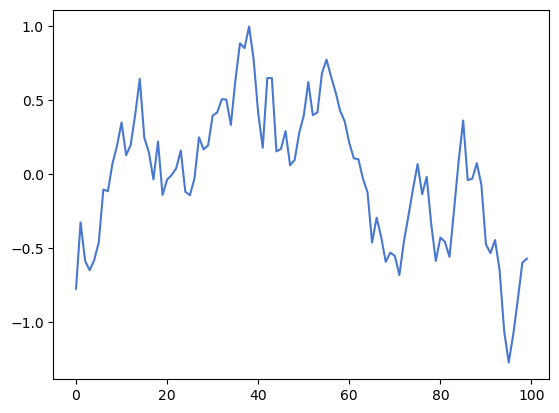

In [676]:
def noise_psd(N, psd = lambda f: 1):
        X_white = np.fft.rfft(np.random.randn(N));
        S = psd(np.fft.rfftfreq(N))
        # Normalize S
        S = S / np.sqrt(np.mean(S**2))
        X_shaped = X_white * S;
        return np.fft.irfft(X_shaped);

def PSDGenerator(f):
    return lambda N: noise_psd(N, f)

@PSDGenerator
def brownian_noise(f):
    return 1/np.where(f == 0, float('inf'), f)

@PSDGenerator
def white_noise(f):
    return 1;

y = brownian_noise(101)
plt.plot(y/y.max())



https://dsp.stackexchange.com/questions/72005/calculate-the-magnitude-and-phase-of-a-signal-at-a-particular-frequency-in-pytho

### Test on 2D data

In [972]:
import pickle
path = 'C:\\Documents\\Data\\FST\\'
filebeginning = '20230421-0913-07_FST_' #here the beginning of the filename, including the date and sample name, is needed
filepath = path + filebeginning

with open(filepath+'qafm_array_raw.pickle', 'rb') as f:
    qafm_data = pickle.load(f)
with open(filepath+'esr_array_raw.pickle', 'rb') as f:
    esr_data = pickle.load(f)
    
data = esr_data['esr_fw']['data']
var_list = esr_data['esr_fw']['coord2_arr']
coord0_num = qafm_data['Height(Dac)_fw']['params']['coord0_num (#)']
coord1_num = qafm_data['Height(Dac)_fw']['params']['coord1_num (#)']

In [973]:
from scipy.fft import fft, ifft, fftfreq
import numpy as np

In [1321]:
x_axis = var_list
resonance_array = np.zeros((data.shape[0],data.shape[1]))
for i in range(data.shape[0]):
    for j in range(data.shape[1]):
        y_raw = np.copy(data[i,j,:])
        y_concatenated = y_raw# np.tile(y_raw, 1)
        y_concatenated -= y_concatenated.mean()
        f_center = x_axis[int(len(x_axis)/2)]
        delta_f_win = np.abs(x_axis[-1]-x_axis[0])

        mod_freq = 1.5 # the modulation frequency of the lockin signal
        T = 1/len(x_axis) / mod_freq #time array is defined to achieve said mod freq. For real, T would be the integration time or bin width
        N = len(y_concatenated)

        x_time = np.linspace(0,T*N,N)

        yf = fft(y_concatenated)
        xf = fftfreq(N, T)
        yplot = 2.0/N* (yf)

        modarg0 = np.abs(xf - mod_freq).argmin()
        phase0 = np.angle(yplot[modarg0])
        f0 = f_center - (phase0 * delta_f_win /2/ np.pi)

        modarg0 = np.abs(xf - 2*mod_freq).argmin()
        phase0 = np.angle(yplot[modarg0])
        f1 = f_center + (phase0/2 * delta_f_win / 2 / np.pi)/2

        modarg0 = np.abs(xf - 3*mod_freq).argmin()
        phase0 = np.angle(yplot[modarg0])
        f2 = f_center + (phase0/3 * delta_f_win / 2 / np.pi)/3

        result = np.mean((f0))

        resonance_array[i,j] = result

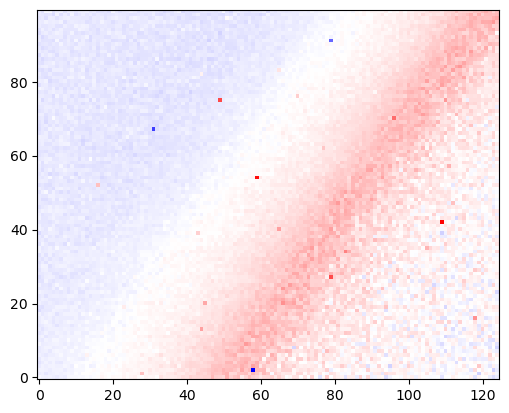

In [1322]:
import matplotlib.pyplot as plt
plt.imshow(resonance_array,cmap='bwr',origin='lower')#, vmin=2.742e9, vmax=2.755e9)
plt.show()

In [1352]:
import time

import datetime
fut = datetime.datetime.now() + datetime.timedelta(hours=1.3)
fut.strftime('%c')

'Wed Sep 27 15:02:16 2023'